In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from astropy.time import Time
from collections import Counter

sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Dark2")

In [49]:
data = pd.read_csv("data/2020oi_data.snana.txt", delimiter='\t')
data = data[data['MJD'] > 57000]
data = data[data['MAG'] > 0]

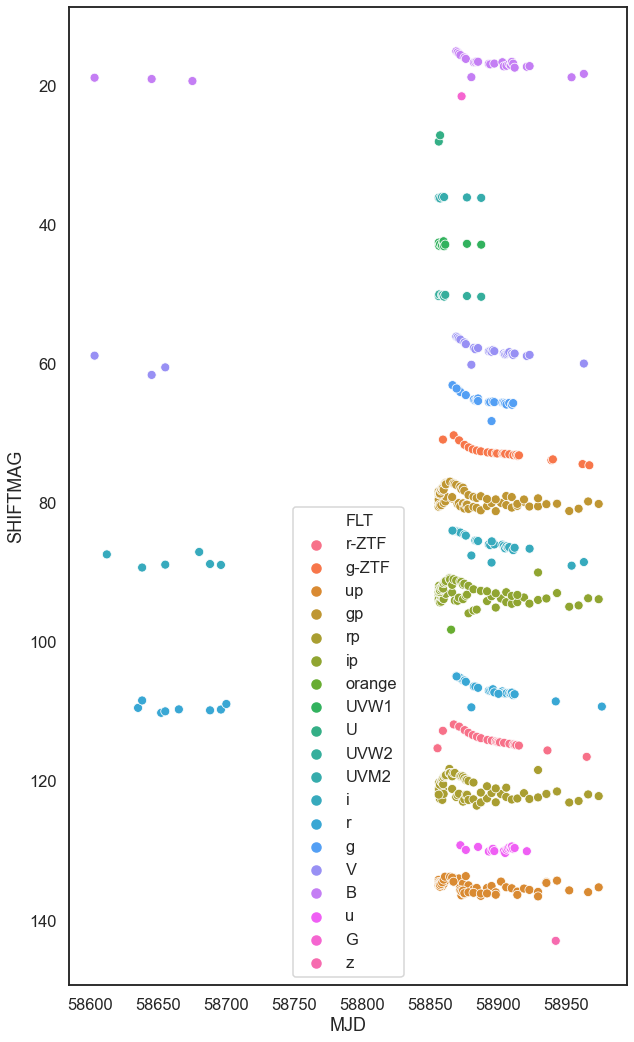

In [50]:
bands = np.unique(data['FLT'])
data['SHIFTMAG'] = data['MAG']
plt.figure(figsize=(10,18))
for i in np.arange(19):
    data.loc[data['FLT'] == bands[i], 'SHIFTMAG'] +=  7*i 
sns.scatterplot(x='MJD', y='SHIFTMAG', hue='FLT', data=data)
plt.gca().invert_yaxis()

In [51]:
Counter(data['INSTRUMENT'])

Counter({'ZTF-Cam': 48,
         'Sinistro': 323,
         'HKO': 1,
         'UVOT': 26,
         'GPC1': 8,
         'Direct/4Kx4K': 137,
         'Gaia-Photometric': 1,
         'Direct/2Kx2K': 31})

In [52]:
#okay, so clearly lots of data, most of it useful. 
#let's fit one band - which has the most data?

In [53]:
from collections import Counter
Counter(data['FLT'])

Counter({'r-ZTF': 24,
         'g-ZTF': 24,
         'up': 70,
         'gp': 86,
         'rp': 82,
         'ip': 85,
         'orange': 1,
         'UVW1': 10,
         'U': 2,
         'UVW2': 8,
         'UVM2': 6,
         'i': 36,
         'r': 37,
         'g': 24,
         'V': 30,
         'B': 30,
         'u': 18,
         'G': 1,
         'z': 1})

In [54]:
bands = ['rp', 'r-ZTF', 'r']
oneBand = data[data['FLT'].isin(bands)]
#instruments = ['Direct/4Kx4K', 'Sinistro']
#oneBand = oneBand[oneBand['INSTRUMENT'].isin(instruments)]
oneBand.sort_values(by=['MJD'], inplace=True)
oneBand = oneBand[oneBand['MAGERR'] < 0.03]
oneBand = oneBand[oneBand['MJD'] > 58800]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


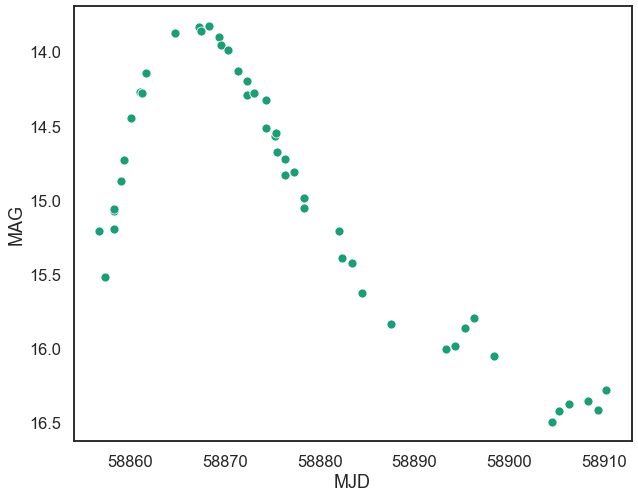

In [55]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='MJD', y='MAG',data=oneBand);
plt.gca().invert_yaxis()

In [56]:
oneBand.drop_duplicates(subset=['MJD', 'MAG'], inplace=True)

In [57]:
import os
from os import listdir
from os.path import isfile, join
from astropy.io import fits
import warnings
from astropy.utils.exceptions import AstropyUserWarning
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=AstropyUserWarning)
warnings.filterwarnings('ignore', category=AstropyWarning)

#rough position of the supernova at the center of the image, in pixels: 
#2251, 2251
XSN = 2251
YSN = 2251

timeArr = []
fixed_optical_df = []
zpts = []
zpts00 = []
path = "/Users/alexgagliano/Documents/Research/2020oi/2020oi_photometry/"
files = [f for f in listdir(path) if isfile(join(path, f))]
#get the REAL photometry:
header_list = ['Xpos','Ypos','Mag','Mag_err','flux','flux_err', 'type', 'peakflux', 'sigx', 'sigxy', 'sigy', 'sky','chisqr','class','FWHM1','FWHM2','FWHM','angle','extendedness','flag','mask','Nmask','RA','Dec','pixchk_Npos','pixchk_Nneg','pixchk_Nmask','pixchk_Ntot','pixchk_Fpos','pixchk_Fneg']
dict_vals = {}
bands = []
for file in files:
    bands.append(file[7])
    hdul = fits.open("/Users/alexgagliano/Documents/Research/2020oi/2020oi_photometry/%s"%file)
    temp = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/2020oi_photometry/%s"%file, names=header_list, skiprows=1, delim_whitespace=True)
    sub = temp[np.abs(temp['Xpos'] - XSN) + np.abs(temp['Xpos'] - YSN)  < 3]
    sub = sub[sub['peakflux'] == np.max(sub['peakflux'].values)]
    timeArr.append(hdul[0].header['MJD-OBS'])
    zpts.append(hdul[0].header['ZPTMAGAV'])
    if hdul[0].header['ZPTMAGAV'] < 1:
        print(file)
    zpts00.append(hdul[0].header['ZPTMAG00'])
    fixed_optical_df.append(sub)

2020oi.i.ut200216.4071_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.i.ut200120.1130_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.r.ut200314.3141_stch_1_r.2020oitmpl.19.stk_1.diff.dcmp
2020oi.i.ut200301.8104_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.i.ut200204.3125_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.r.ut200303.1098_stch_1_r.2020oitmpl.19.stk_1.diff.dcmp


In [58]:
fixed_optical_df = pd.concat(fixed_optical_df, ignore_index=True)
fixed_optical_df['time'] = timeArr
fixed_optical_df['zpt_av'] = zpts
fixed_optical_df['zpt_00'] = zpts00

fixed_optical_df['band'] = bands

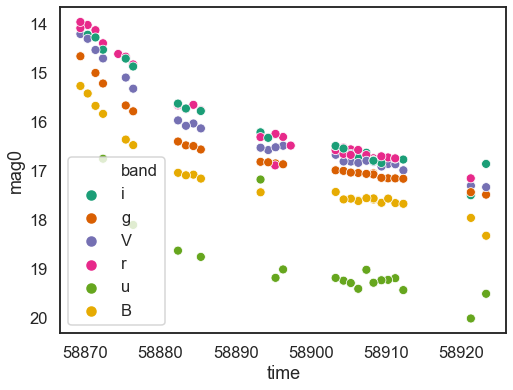

In [59]:
fixed_optical_df['mag0'] = -2.5*np.log10(fixed_optical_df['flux']) + fixed_optical_df['zpt_av']

#dropping the failed points for now
fixed_optical_df = fixed_optical_df[fixed_optical_df['mag0'] > 0]

plt.figure(figsize=(8,6))
sns.set_context("talk")
sns.scatterplot('time', 'mag0', hue='band', data=fixed_optical_df)
plt.gca().invert_yaxis()

fixed_optical_df['MJD'] = fixed_optical_df['time']
fixed_optical_df['MAG'] = fixed_optical_df['mag0']
fixed_optical_df['MAGERR'] = fixed_optical_df['Mag_err']
fixed_optical_df['FLT'] = fixed_optical_df['band']

newData = fixed_optical_df[['MJD', 'MAG', 'MAGERR', 'FLT']]
newData = newData[newData['FLT'] == 'r']

In [60]:
#let's fit a quadratic to the rise and a linear to the fall (rough start for now)
peakTime = oneBand.loc[oneBand['MAG'] == np.min(oneBand['MAG']), 'MJD'].values[0]

In [61]:
#get the points with lowest error
oneBand = pd.concat([oneBand, newData])
oneBand.sort_values(by=['MJD'], inplace=True)
rise = oneBand[oneBand['MJD'] < peakTime]
peak = oneBand[np.abs(oneBand['MJD'] - peakTime) < 0.2]
#taking the point with lower error
fall = oneBand[oneBand['MJD'] > peakTime]

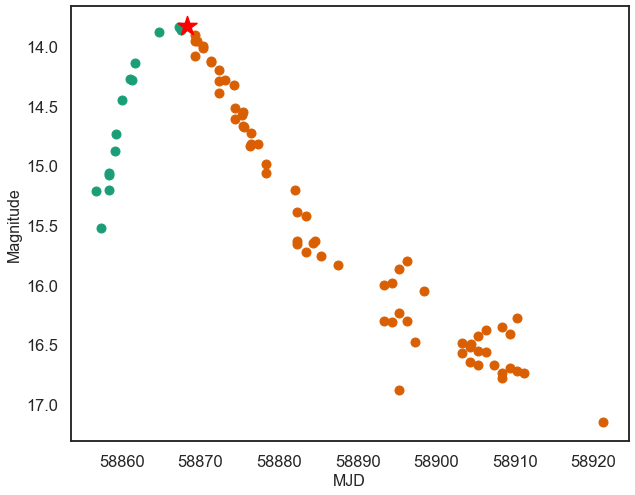

In [62]:
plt.figure(figsize=(10,8))
plt.plot(rise['MJD'], rise['MAG'], 'o')
plt.scatter(peak['MJD'], peak['MAG'], marker='*', s=400, zorder=100, c='r')
plt.plot(fall['MJD'], fall['MAG'], 'o')
plt.xlabel("MJD",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.gca().invert_yaxis()

In [63]:
import matplotlib.pyplot as plt
zRise = np.polyfit(rise['MJD'].values.astype(float), rise['MAG'].values, 2)
zFall = np.polyfit(fall['MJD'].values.astype(float), fall['MAG'].values, 2)

In [64]:
def fit(time):
    PT = peak['MJD'].values
    time = np.array(time)
    riseTimes = time[time <= PT]
    fallTimes = time[time > PT]
    riseMag = zRise[2] + zRise[1]*riseTimes + zRise[0]*riseTimes**2
    fallMag = zFall[2] + zFall[1]*fallTimes + zFall[0]*fallTimes**2 #+ zFall[0]*fallTimes**3
    mag = np.concatenate([riseMag, fallMag])
    return mag

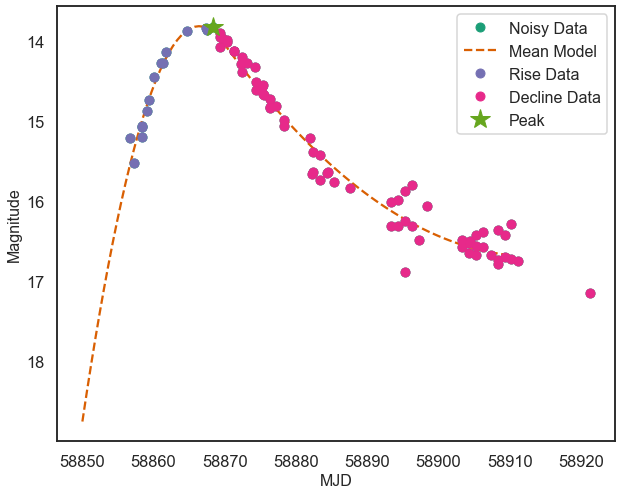

In [65]:
newTime = np.linspace(58850, 58910,num=100)
plt.figure(figsize=(10,8))
plt.plot(oneBand['MJD'].values, oneBand['MAG'].values, 'o', label='Noisy Data');
plt.plot(newTime, fit(newTime), '--',label='Mean Model');
plt.plot(rise['MJD'].values, rise['MAG'].values, 'o', label='Rise Data');
plt.plot(fall['MJD'].values, fall['MAG'].values, 'o', label='Decline Data');
plt.plot(peak['MJD'].values, peak['MAG'].values, '*', markersize=20, label='Peak');
plt.gca().invert_yaxis()
plt.xlabel("MJD",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.legend(fontsize=16);

In [66]:
import george
from george.modeling import Model

class MeanModel(Model):
    parameter_names = ('r1', 'r2', 'r3', 'f1', 'f2', 'f3')
    def get_parameter_vector(self):
        return np.array([self.r1, self.r2, self.r3, self.f1, self.f2, self.f3])
    def set_vector(self, vec):
        self.r1 = vec[0]
        self.r2 = vec[1]
        self.r3 = vec[2]
        self.f1 = vec[3]
        self.f2 = vec[4]
        self.f3 = vec[5]
        #k.set_parameter_vector(k.get_parameter_vector() + np.random.randn(2))
    def set_parameter_vector(self, vec): 
        return set_vector(self, vec)
    def get_value(self, time):
        PT = peak['MJD'].values
        time = np.array(time)
        riseTimes = time[time <= PT]
        fallTimes = time[time > PT]
        riseMag = self.r3 + self.r2*riseTimes + self.r1*riseTimes**2
        fallMag = self.f3 + self.f2*fallTimes + self.f1*fallTimes**2 
        soln = np.concatenate([riseMag, fallMag])
        return soln

In [67]:
p0 = np.concatenate([zRise, zFall])

In [68]:
def lnprob(p):
    #let's make them all flat priors - 
    logBoundL = np.array([1.e-4, -1.e3, 1.e7, 1.e-4, -1.e3, 1.e6])
    logBoundR = np.array([1.e-3, -1.e2, 5.e7, 1.e-3, -1.e2, 5.e6])
    for i in np.arange(6):
        if (p[i] < logBoundL[i]) or (p[i] > logBoundR[i]):
            return -np.inf
    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    return gp.lnlikelihood(oneBand['MAG'], quiet=True)

In [69]:
#oneBand_full = oneBand.copy()
#oneBand = oneBand_full.sample(int(len(oneBand_full)/4))
#oneBand = oneBand.sort_values(by=['MJD'])

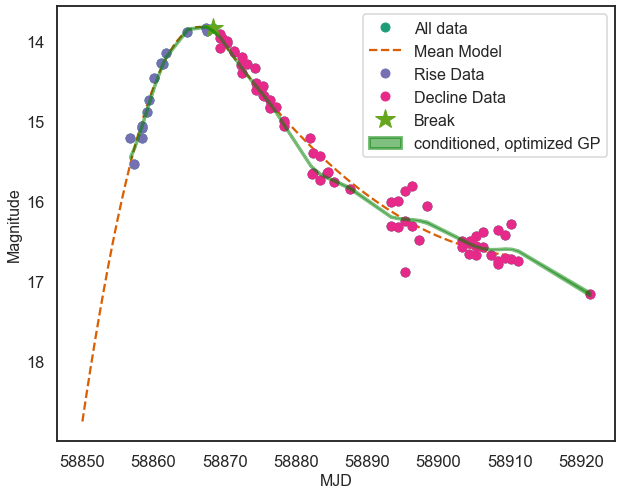

In [70]:
import scipy.optimize as op
from george import kernels

kernel = kernels.ExpSquaredKernel(50.0)

gp = george.GP(mean=MeanModel(r1=zRise[0], r2=zRise[1], r3=zRise[2], f1=zFall[0], f2=zFall[1], f3=zFall[2]), kernel=kernel)

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(oneBand['MAG'].values, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(oneBand['MAG'].values, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(oneBand['MJD'].values, oneBand['MAGERR'].values)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

ypred2, cov = gp.predict(oneBand['MAG'].values, oneBand['MJD'].values, return_cov=True)
std = np.sqrt(np.diag(cov))

# plot the data
plt.figure(figsize=(10,8))
plt.fill_between(oneBand['MJD'].values, ypred2+std, ypred2-std, color="g", lw=3, alpha=0.5, label='conditioned, optimized GP', zorder=100)
newTime = np.linspace(58850, 58910,num=100)
plt.plot(oneBand['MJD'].values, oneBand['MAG'].values, 'o', label='All data');
plt.plot(newTime, fit(newTime), '--',label='Mean Model');
plt.plot(rise['MJD'].values, rise['MAG'].values, 'o', label='Rise Data');
plt.plot(fall['MJD'].values, fall['MAG'].values, 'o', label='Decline Data');
plt.plot(peak['MJD'].values, peak['MAG'].values, '*', markersize=20, label='Break');
plt.gca().invert_yaxis()
plt.xlabel("MJD",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.legend(fontsize=16);

In [189]:
import theano.tensor as tt
import pymc3 as pm

class MeanModel(pm.gp.mean.Mean):

    def __init__(self, r1, r2, r3, f1, f2, f3):
        #Mean.__init__(self)
        self.r1 = r1
        self.r2 = r2
        self.r3 = r3
        self.f1 = f1
        self.f2 = f2
        self.f3 = f3
        
    def __call__(self, X):
        #return tt.alloc(1.0, X.shape[0]) * self.c
        PT = peak['MJD'].values[0]
        X = np.array(X)
        riseTimes = X[X <= PT]
        fallTimes = X[X > PT]
        #print(self.r1)
        riseMag = self.r3 + self.r2*riseTimes + self.r1*riseTimes**2
        fallMag = self.f3 + self.f2*fallTimes + self.f1*fallTimes**2 
        soln = np.concatenate([riseMag, fallMag])
        return soln

In [197]:
with pm.Model() as marginal_gp_model:

    l = pm.Normal('l', 0.1, sigma=5, shape=1)
    cov_func = pm.gp.cov.ExpQuad(1, ls=l)

    # The scale of the white noise term can be provided,
    #r1 = pm.Normal('r1', p0[0], sigma=10, shape=1)
    #r2 = pm.Normal('r2', p0[1], sigma=10, shape=1)
    #r3 = pm.Normal('r3', p0[2], sigma=10, shape=1)
    #f1 = pm.Normal('f1', p0[3], sigma=10, shape=1)
    #f2 = pm.Normal('f2', p0[4], sigma=10, shape=1)
    #f3 = pm.Normal('f3', p0[5], sigma=10, shape=1)
    
    #f3 = pm.Normal('f3', 0, sigma=100, shape=n_counties)
    
    # Specify the GP.  The default mean function is `Zero`.
    #gp = pm.gp.Marginal(MeanModel(r1=r1,r2=r2,r3=r3,f1=f1,f2=f2,f3=f3), cov_func=cov_func)
    gp = pm.gp.Marginal(MeanModel(r1=p0[0],r2=p0[1],r3=p0[2],f1=p0[3],f2=p0[4],f3=p0[5]), cov_func=cov_func)
    
    sigma = pm.HalfCauchy("sigma", beta=0.5)

    #y_ = gp.marginal_likelihood("y", X=oneBand['MJD'].values[:, None], y=oneBand['MAG'].values, noise=oneBand['MAGERR'].values)
    y_ = gp.marginal_likelihood("y", X=oneBand['MJD'].values[:, None], y=oneBand['MAG'].values, noise=sigma)
    mp = pm.find_MAP()

/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = 12.54, ||grad|| = 2.2499e-05: 100%|██████████| 56/56 [00:00<00:00, 617.22it/s]  


In [198]:
# new values from x=0 to x=20
X_new = np.linspace(58856.698, 58921.23906, 60)[:,None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

100%|██████████| 2000/2000 [00:11<00:00, 167.88it/s]


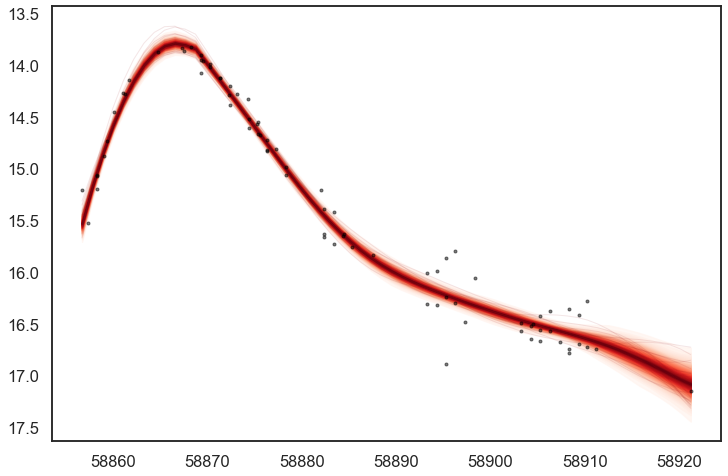

In [199]:
# plot the results
fig = plt.figure(figsize=(12,8)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(oneBand['MJD'], oneBand['MAG'], 'ok', ms=3, alpha=0.5, label="Observed data");
plt.gca().invert_yaxis()

In [ ]:
with pm.Model() as hierarchical_model: 

    # Hyperpriors for group nodes
    mu_a = pm.Normal('slope', mu=-3, sigma=0.5)
    sigma_a = pm.HalfNormal('slopescatter', 0.5)
    sigma_b = pm.HalfNormal('dmuscatter', 5.)
    Z = pm.Normal('Z', mu=25, sigma=5.)
    
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=nhosts)
    dmu = pm.Normal('dmu', mu=0, sigma=sigma_b, shape=nhosts)
    
    sig_int = 0.1
    
    mpred = a[host_idx]*logP + Z + dmu[host_idx]
    like = pm.Normal('likelihood', mu=mpred, sigma =np.sqrt(sig_int**2. + err**2), observed=mobs)
    
    hm = pm.sample(2000, tune=500, target_accept=0.9)